## Imports

In [164]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table 
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import ticker

import gym
import d4rl

# https://stackoverflow.com/questions/25412513/inline-images-have-low-quality
# %config InlineBackend.figure_format = 'svg'

# Use better font for plotting
# https://python4astronomers.github.io/plotting/publication.html#font-sizes
from matplotlib import rc
rc('font', family='serif')

print(os.getcwd())

/home/yangz2/rl_nju/d4rl_evaluations/results_analysis


In [2]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [116]:
class ResultReader:
    
    def __init__(self, eval_freq=5e3, num_grad_steps=5e5):

        self.algo_to_result = {}
        
        base_dir = '../results'
        
        for algo in [fname for fname in listdir_nohidden(base_dir) if os.path.isdir(os.path.join(base_dir, fname))]:
            algo_dir = os.path.join(base_dir, algo)
            
            task_to_trainCurveAvg = {}  # each such dict is called the "result" for the algorithm
            
            for task in [fname for fname in listdir_nohidden(algo_dir) if os.path.isdir(os.path.join(algo_dir, fname))]:
                task_dir = os.path.join(algo_dir, task)
                
                trainCurveAccum = np.zeros((int(num_grad_steps // eval_freq), ))
                num_seeds = 0
                
                for seed in [fname for fname in listdir_nohidden(task_dir) if os.path.isdir(os.path.join(task_dir, fname))]:
                    if algo == 'BCQ':
                        trainCurveAccum += np.array(np.load(os.path.join(task_dir, seed, 'progress.npy')))
                    elif algo == 'BEAR' or algo == 'CQL':
                        try:
                            trainCurve = pd.read_csv(os.path.join(task_dir, seed, 'progress.csv'))['evaluation/Average Returns'].to_numpy()
                            if len(trainCurve) == 100:
                                trainCurveAccum += trainCurve
                        except:
                            print("An exception occurred")
                    elif algo == 'BC':
                        try:
                            with open(os.path.join(task_dir, seed, 'results.txt')) as txt_f:
                                trainCurve = np.array([float(line.rstrip().rstrip(']').lstrip('[]')) for line in txt_f.readlines()])
                            if len(trainCurve) == 100:
                                trainCurveAccum += trainCurve
                        except:
                            print("An exception occurred")
                    num_seeds += 1
                    
                trainCurveAvg = trainCurveAccum / num_seeds
                
                task_to_trainCurveAvg[task] = trainCurveAvg
                
            self.algo_to_result[algo] = task_to_trainCurveAvg
                
        self.eval_freq = eval_freq
        self.num_grad_steps = num_grad_steps
                
    @staticmethod
    def exp_smoother(scores, alpha=0.9):
        smoothed_scores = []
        curr = scores[0]
        for i, score in enumerate(scores):
            smoothed_scores.append(curr)
            curr = alpha * curr + (1 - alpha) * score
        return smoothed_scores
    
    @property
    def grad_steps(self):
        return np.arange(int(self.num_grad_steps / self.eval_freq)) * self.eval_freq + self.eval_freq
    
    def plottable(self, algo_name, task_name):
        if algo_name in self.algo_to_result.keys():
            if task_name in self.algo_to_result[algo_name].keys():
                return True
            else:
                return False
        else:
            return False
                
    def normalized_scores(self, algo_name:str, task_name:str) -> tuple:
        raw_scores = self.algo_to_result[algo_name][task_name]
        min_score = d4rl.infos.REF_MIN_SCORE[f'{task_name}']
        max_score = d4rl.infos.REF_MAX_SCORE[f'{task_name}']
        norm_scores = (raw_scores - min_score) / (max_score - min_score) * 100
        return self.exp_smoother(norm_scores)

In [4]:
d4rl_scores_csv_path = '/home/yangz2/rl_nju/offline-rl-notes/d4rl-paper-extractions/d4rl_table_2_gym_extracted.csv'
cql_scores_csv_path = '/home/yangz2/rl_nju/offline-rl-notes/d4rl-paper-extractions/cql_table_1_extracted.csv'

In [5]:
d4rl_scores = pd.read_csv(d4rl_scores_csv_path)
d4rl_scores = d4rl_scores.set_index('task')
d4rl_tasks = d4rl_scores.index.tolist()

cql_scores = pd.read_csv(cql_scores_csv_path)
cql_scores = cql_scores.set_index('task')
cql_tasks = cql_scores.index.tolist()

In [124]:
algos = [
    'BCQ',
    'BEAR',
    'CQL',
    'BC'
] 

In [44]:
tasks = [
    'halfcheetah-random-v1', 
    'halfcheetah-medium-v1', 
    'halfcheetah-medium-replay-v1',
    'halfcheetah-expert-v1', 
    'halfcheetah-medium-expert-v1',
]

In [8]:
task_to_baseline = {}
for task in tasks:
    
    min_score = d4rl.infos.REF_MIN_SCORE[f'{task}']
    max_score = d4rl.infos.REF_MAX_SCORE[f'{task}']
    
    env = gym.make(task)
    ds = env.get_dataset()
    
    per_traj_return = np.sum(ds['rewards']) / (np.sum(ds['terminals']) + np.sum(ds['timeouts']))
    task_to_baseline[task] = (per_traj_return - min_score) / (max_score - min_score) * 100

/home/yangz2/miniconda3/envs/nju_rl_p37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
task_to_baseline

{'halfcheetah-random-v1': -0.05345686739695595,
 'halfcheetah-medium-v1': 40.49039866465467,
 'halfcheetah-medium-replay-v1': 27.17209753098163,
 'halfcheetah-expert-v1': 80.25291452276983,
 'halfcheetah-medium-expert-v1': 60.371662634704506}

In [147]:
reproduce_df = pd.DataFrame(index=algos, columns=tasks)
# reproduce_df = reproduce_df.fillna(0) # with 0s rather than NaNs

In [148]:
reproduce_df.head()

,halfcheetah-random-v1,halfcheetah-medium-v1,halfcheetah-medium-replay-v1,halfcheetah-expert-v1,halfcheetah-medium-expert-v1
BCQ,NaN,NaN,NaN,NaN,NaN
BEAR,NaN,NaN,NaN,NaN,NaN
CQL,NaN,NaN,NaN,NaN,NaN
BC,NaN,NaN,NaN,NaN,NaN


In [132]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [133]:
default_colors[:4]

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

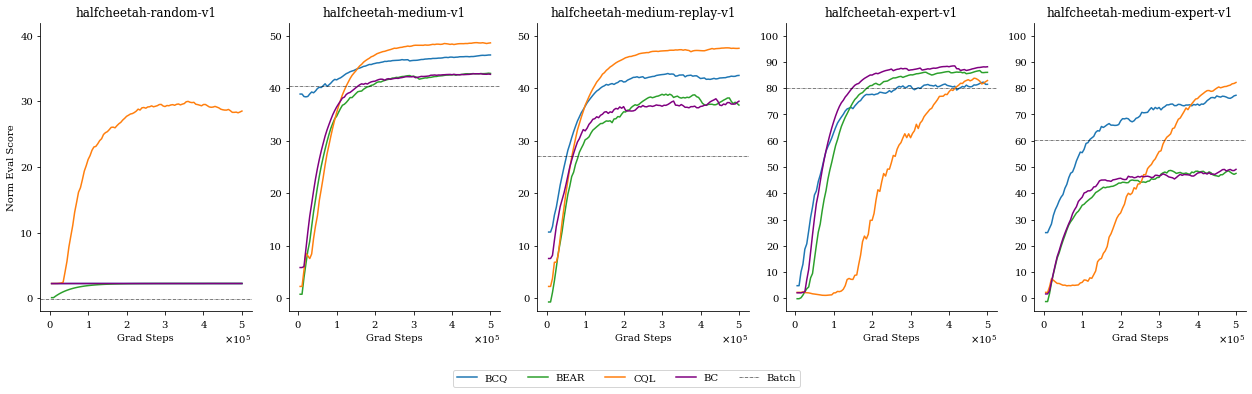

In [160]:
height = 5
width = 3.5
fig = plt.figure(figsize=(width * len(tasks), height))

res = ResultReader()

# colors = plt.cm.rainbow(np.linspace(0,1,len(algos)))
colors_to_use = ['#1f77b4', '#2ca02c', '#ff7f0e', 'purple']

for i, task_name in enumerate(tasks):

    fig.add_subplot(int(f'1{len(tasks)}{i+1}'))
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    for j, algo_name in enumerate(algos):
        
        if res.plottable(algo_name, task_name):
            
            if task_name[:-3] in d4rl_scores.index and algo_name in d4rl_scores.columns:
                published_score = d4rl_scores.at[task_name[:-3], algo_name]
#             elif task_name[:-3] in cql_scores.index and algo_name in cql_scores.columns:
#                 published_score = cql_scores.at[task_name[:-3], algo_name]
            else:
                published_score = None

            if published_score is not None:
#                 plt.axhline(published_score, alpha=0.4, c=colors_to_use[j], label=f'{algo_name} (D4RL)')
                reproduce_df.at[algo_name, task_name] = round(res.normalized_scores(algo_name, task_name)[-1] / published_score * 100, 1)
                    
            plt.plot(
                res.grad_steps, res.normalized_scores(algo_name, task_name), 
                label=algo_name, 
                c=colors_to_use[j], 
                linewidth=1.5
            )
                
    plt.axhline(task_to_baseline[task_name], c='black', linestyle='-.', linewidth=0.5, label='Batch')
    
    plt.title(task_name)
    plt.xlabel('Grad Steps')
    if i == 0:
        plt.ylabel('Norm Eval Score')

    plt.xlim(-0.05*max(res.grad_steps), max(res.grad_steps)+0.05*max(res.grad_steps))
    plt.xticks(np.linspace(0, max(res.grad_steps), 6))
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    plt.gca().xaxis.set_major_formatter(formatter) 

    if 'expert' in task_name:
        plt.ylim(-5, 100+5)
        plt.yticks(np.linspace(0, 100, 11))
    elif 'medium' in task_name:
        plt.ylim(-2.5, 50+2.5)
        plt.yticks(np.linspace(0, 50, 6))
    elif 'random' in task_name:
        plt.ylim(-40*0.05, 40*1.05)
        plt.yticks(np.linspace(0, 40, 5))
    
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(algos)+1, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.savefig('halfcheetah-v1-trainCurves.svg', bbox_inches = 'tight', pad_inches = 0.1)

In [161]:
reproduce_df 

,halfcheetah-random-v1,halfcheetah-medium-v1,halfcheetah-medium-replay-v1,halfcheetah-expert-v1,halfcheetah-medium-expert-v1
BCQ,102.3,113.8,111.1,NaN,119.5
BEAR,9.0,102.7,95.3,NaN,89.0
CQL,80.6,109.5,103.0,NaN,131.7
BC,107.2,118.2,97.7,NaN,137.2


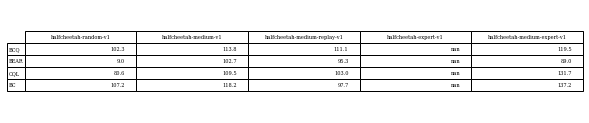

In [178]:
fig = plt.figure(figsize=(10, 2))
fig.add_subplot(111, frame_on=False)

# ax = plt.subplot(111, ) # no visible frame
plt.gca().xaxis.set_visible(False)  # hide the x axis
plt.gca().yaxis.set_visible(False)  # hide the y axis

table(plt.gca(), reproduce_df, loc='center')  # where df is your data frame

plt.savefig('reproduced_divide_by_claimed_percentage.png', dpi=300, bbox_inches='tight', pad_inches=0)